In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from io import BytesIO
import gc

import numpy as np
import torch
import torch.nn as nn
from incense import ExperimentLoader
from pyrsistent import thaw
from ignite.engine import create_supervised_evaluator

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


if '../src' not in sys.path:
    sys.path.append('../src')

from training.loss import get_metric
from dataset.transforms import load_triplets, Unsupervised, Dsprites
from dataset.sprites import load_raw as load_dsprites, SupervisedLoader, BatchGenerator
from analysis.sampling import *
from analysis.traversal import traverse_all
from analysis.metrics import EastwoodScore

if '../scripts/' not in sys.path:
    sys.path.append('../scripts/')

from ingredients.composers import create_composer
import configs.sprite_filters as filters

# Disable grad globally
torch.set_grad_enabled(False)

# Config options
use_cuda = True
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')

sns.set(color_codes=True);

In [18]:
import json

def load_composer(path, device):
    meta = path + 'config.json'
    param_vals = path + 'trained-model.pth'
    
    with open(meta) as f:
        architecture = json.load(f)['model']
        
    if 'transformer_layers' in architecture:
        del architecture['transformer_layers']
    
    if 'mixing_layer' not in architecture:
        architecture['mixing_layer'] = None
    
    composer = create_composer(**architecture)
    
    state_dict = torch.load(param_vals)
    
    if "projector.ref_proj.weight" not in state_dict:
        state_dict["projector.ref_proj.weight"] = state_dict["ref_proj.weight"]
        del state_dict["ref_proj.weight"]
    
    if "projector.ref_proj.bias" not in state_dict:
        state_dict["projector.ref_proj.bias"] = state_dict["ref_proj.bias"]
        del state_dict["ref_proj.bias"]
        
    if "projector.trans_proj.weight" not in state_dict:
        state_dict["projector.trans_proj.weight"] = state_dict["trans_proj.weight"]
        del state_dict["trans_proj.weight"]
        
    if "projector.trans_proj.bias" not in state_dict:
        state_dict["projector.trans_proj.bias"] = state_dict["trans_proj.bias"]
        del state_dict["trans_proj.bias"]
    
    
    composer.load_state_dict(state_dict)
    
    return composer.to(device=device).eval()


def get_recons(data, model):
    recons = model(data.to(device=device))[0].sigmoid()
    recons = recons.cpu().numpy()
    return recons


def get_transforms(data, model):
    img, action = data
    data = img.to(device=device), action.to(device=device)
    
    recons = model(data)[0].sigmoid()
    recons = recons.cpu().numpy()
    return recons


def model_scores(models, data):
    metric = {'name': 'recons_nll', 'params': {}}
    scores =  []
    for m in models:
        engine = create_supervised_evaluator(m, {'nll': get_metric(metric)}, device)
        metrics = engine.run(Unsupervised(data, 64, False)).metrics
        nll = metrics['nll']
        scores.append(nll)
        
    return pd.Series(scores)


def clean_memory():
    try:
        del data
    except UnboundLocalError:
        pass
    
    try:
        del metric_data
    except UnboundLocalError:
        pass

    try:
        del disentanglement_metric
    except UnboundLocalError:
        pass
    
    try:
        del raw
    except UnboundLocalError:
        pass
    
    try:
        del raw_extrp_test
    except UnboundLocalError:
        pass
    
    gc.collect()

# Dataset path
factors = ['shape', 'scale', 'orientation', 'pos x', 'pos y']
dsprite_path = '../data/raw/dsprites/dsprite_train.npz'

# Save paths
presentation_folder = '/home/milton/Dropbox/Apps/Overleaf/Presentation: Compositionality in Generative Models/plots/'

# Checking composition

First we will test the models on the tasks that they were trained. Then we will proceed to test the VAE on reconstructing unseen combinations.

## Full Data

We start with the full data set

In [4]:
composer = load_composer('../data/sims/composition/14/', device)
model_names = ['composer']

### Disentanglment analysis

In [5]:
data = load_dsprites(dsprite_path, filters.low_scale_filter)

metric_data =  SupervisedLoader(lambda z, c: z[:, 1:], data, 200)
disentanglement_metric = EastwoodScore(metric_data, n_factors=5)

training_scores = disentanglement_metric(composer.vae)
training_scores_R = disentanglement_metric.R_

In [6]:
total_disent_score, disent_scores, completness_scores = zip(training_scores)
R_matrices = [training_scores_R]

In [10]:
data_names = ['train']

idx = pd.MultiIndex.from_product([data_names, range(len(disent_scores[0]))], names=['data', 'latent'])
disent_scores = pd.Series(np.concatenate(disent_scores), index=idx)
disent_scores.name = 'disentanglement'

idx = pd.MultiIndex.from_product([data_names, factors], names=['data', 'factor'])
completness_scores = pd.Series(np.concatenate(completness_scores), index=idx)
completness_scores.name = 'completeness'

idx = pd.MultiIndex.from_product([data_names], names=['data'])
overall_disent_score = pd.Series(total_disent_score, index=idx)
overall_disent_score.name = 'overall disentanglement'

full_data_disentanglement = overall_disent_score

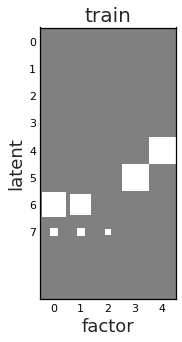

In [8]:
from analysis.hinton import hinton

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

for i in range(len(data_names)):
    hinton(R_matrices[i], 'factor', 'latent', ax=axes, fontsize=18)
    axes.set_title('{0}'.format(data_names[i]), fontsize=20)
    
fig.savefig(presentation_folder + 'composition_full_data_rmatrix.pdf')

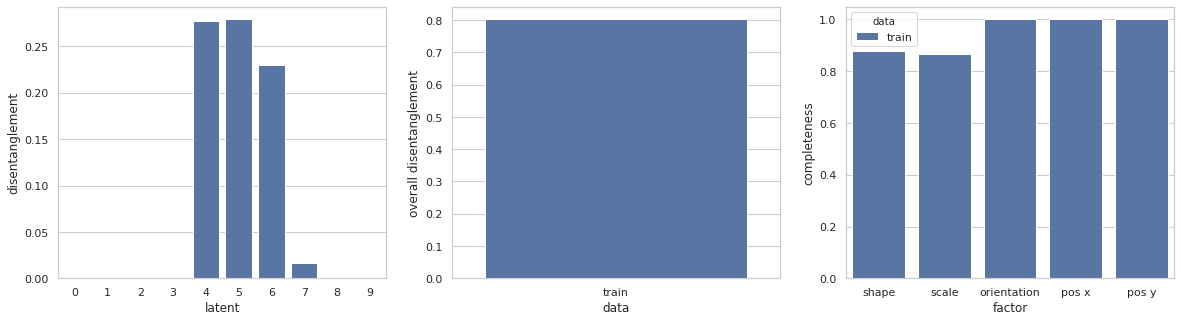

In [11]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, axes = plt.subplots(1, 3, figsize=(20, 5))


sns.barplot(data=disent_scores.reset_index(), hue='data', x='latent', y='disentanglement', ax=axes[0])
sns.barplot(data=overall_disent_score.reset_index(), hue='data', x='data', y='overall disentanglement', ax=axes[1])
sns.barplot(data=completness_scores.reset_index(), hue='data', x='factor', y='completeness', ax=axes[2])

axes[0].legend_.remove()
axes[1].legend_.remove()

fig.savefig(presentation_folder + 'composition_full_data_dis.pdf')

### Training data reconstructions

In [5]:
batch_size = 10

idx = load_triplets(dsprite_path ,'../data/preproc/triplets/half-scales.npz').source_idx

data = Dsprites(*load_dsprites(dsprite_path, filters.low_scale_filter)[idx])

del idx

train_inputs, real_train, _ = next(iter(BatchGenerator(data, batch_size=batch_size)))

train_recons = [get_recons(train_inputs.flatten(start_dim=1), composer.vae)]

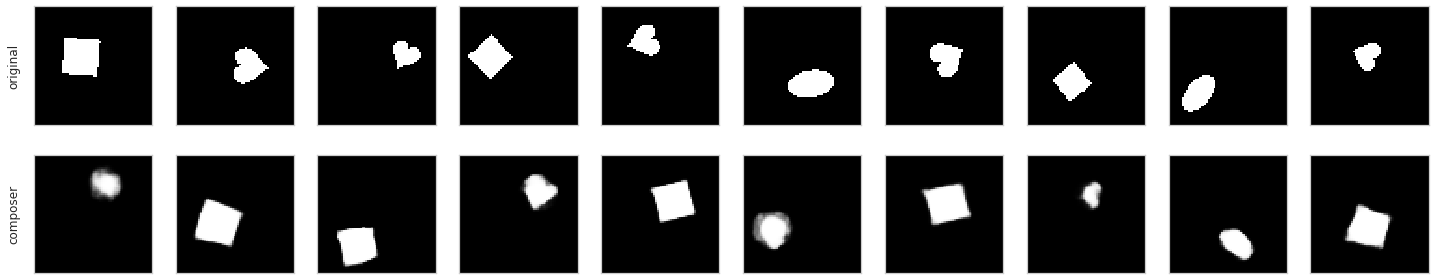

In [6]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(len(model_names) + 1, batch_size, figsize=(25, 5))

for i, images in enumerate(zip(train_inputs, *train_recons)):
    for j, (img, ylab) in enumerate(zip(images, ['original'] + model_names)):
        axes[j, i].imshow(img.reshape(64, 64), cmap='Greys_r')
        if i == 0:
            axes[j, i].set_ylabel(ylab)
    
for ax in axes.reshape(-1):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
# fig.suptitle('VAE reconstruction on training set');
fig.savefig(presentation_folder + 'composition_full_data_reconstruction.pdf')

### Training data transformations

In [14]:
clean_memory()

data = load_triplets(dsprite_path ,'../data/preproc/triplets/half-scales.npz')
data = next(iter(Unsupervised(data, 10, shuffle=True, random_state=1234)))

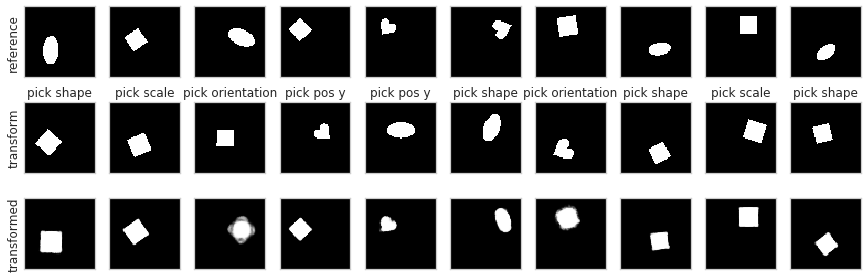

In [15]:
sns.set_style("whitegrid", {'axes.grid' : False})
batch_size = 10

transforms = get_transforms(data[0], composer)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.T

images, dim = data[0]
ref, changes = images.chunk(2, 1)
ref = ref.squeeze(1)
changes = changes.squeeze(1)
dim = dim.to(dtype=torch.long)

for r, c, d, t, ax in zip(ref, changes, dim, transforms, axes):
    ax[0].imshow(r.reshape(64, 64), cmap='Greys_r')
    
    ax[1].set_title('pick {}'.format(factors[d.nonzero().item() - 1]))
    ax[1].imshow(c.reshape(64, 64), cmap='Greys_r')
    
    ax[2].imshow(t.reshape(64, 64), cmap='Greys_r')
    
axes[0, 0].set_ylabel('reference')
axes[0, 1].set_ylabel('transform')
axes[0, 2].set_ylabel('transformed')
    
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig(presentation_folder + 'composition_full_data_transform.pdf')

## Blank side

We start with the full extrapolation test. This probably won't work but we can work down from there.

In [9]:
composer = load_composer('../data/sims/composition/13/', device)

In [10]:
raw = load_triplets(dsprite_path ,'../data/preproc/triplets/blank_side_train.npz')
training_scores = model_scores([composer], raw)

del raw
gc.collect()

raw_extrp_test = load_triplets(dsprite_path, '../data/preproc/triplets/blank_side_test.npz')
test_scores = model_scores([composer], raw_extrp_test)

del raw_extrp_test
gc.collect()

full_extrapolation_scores = pd.concat([training_scores, test_scores], keys=['training', 'test'], names=['dataset'])

### Disentanglment analysis

In [17]:
raw = load_dsprites(dsprite_path, lambda v, c: filters.blank_side_train(0.25, v, c))

metric_data =  SupervisedLoader(lambda z, c: z[:, 1:], raw, 200)
disentanglement_metric = EastwoodScore(metric_data, n_factors=5)

training_scores = disentanglement_metric(composer.vae)
training_scores_R = disentanglement_metric.R_

In [12]:
raw = load_dsprites(dsprite_path, lambda v, c: filters.blank_side_test(0.25, v, c))

metric_data =  SupervisedLoader(lambda z, c: z[:, 1:], raw, 200)
disentanglement_metric = EastwoodScore(metric_data, n_factors=5)

test_scores = disentanglement_metric(composer.vae)
test_scores_R = disentanglement_metric.R_

In [13]:
total_disent_score, disent_scores, completness_scores = zip(training_scores, test_scores)
R_matrices = [training_scores_R, test_scores_R]

In [14]:
data_names = ['train', 'test']

idx = pd.MultiIndex.from_product([data_names, range(len(disent_scores[0]))], names=['data', 'latent'])
disent_scores = pd.Series(np.concatenate(disent_scores), index=idx)
disent_scores.name = 'disentanglement'

idx = pd.MultiIndex.from_product([data_names, factors], names=['data', 'factor'])
completness_scores = pd.Series(np.concatenate(completness_scores), index=idx)
completness_scores.name = 'completeness'

idx = pd.MultiIndex.from_product([data_names], names=['data'])
overall_disent_score = pd.Series(total_disent_score, index=idx)
overall_disent_score.name = 'overall disentanglement'

full_extrapolation_disent = overall_disent_score

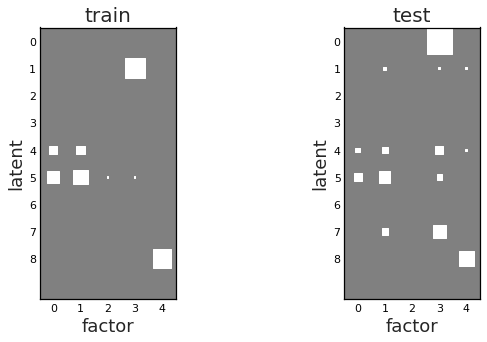

In [10]:
from analysis.hinton import hinton

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(len(data_names)):
    hinton(R_matrices[i], 'factor', 'latent', ax=axes[i], fontsize=18)
    axes[i].set_title('{0}'.format(data_names[i]), fontsize=20)
    
fig.savefig(presentation_folder + 'composition_full_extrp_rmatrix.pdf')

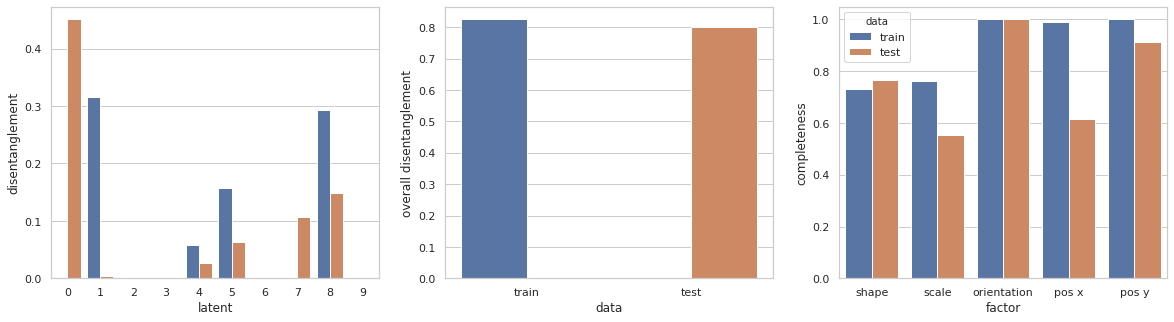

In [11]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, axes = plt.subplots(1, 3, figsize=(20, 5))


sns.barplot(data=disent_scores.reset_index(), hue='data', x='latent', y='disentanglement', ax=axes[0])
sns.barplot(data=overall_disent_score.reset_index(), hue='data', x='data', y='overall disentanglement', ax=axes[1])
sns.barplot(data=completness_scores.reset_index(), hue='data', x='factor', y='completeness', ax=axes[2])

axes[0].legend_.remove()
axes[1].legend_.remove()

fig.savefig(presentation_folder + 'composition_full_extrp_dis.pdf')

### Training data transformations

In [10]:
data = load_triplets(dsprite_path ,'../data/preproc/triplets/blank_side_train.npz')
data = next(iter(Unsupervised(data, 10, shuffle=True, random_state=1234)))

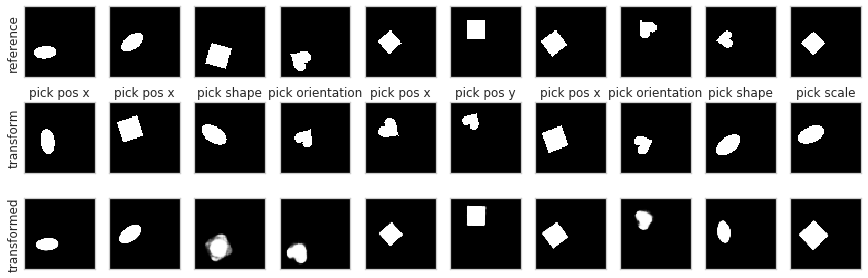

In [11]:
sns.set_style("whitegrid", {'axes.grid' : False})

transforms = get_transforms(data[0], composer)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.T

images, dim = data[0]
ref, changes = images.chunk(2, 1)
ref = ref.squeeze(1)
changes = changes.squeeze(1)
dim = dim.to(dtype=torch.long)

for r, c, d, t, ax in zip(ref, changes, dim, transforms, axes):
    ax[0].imshow(r.reshape(64, 64), cmap='Greys_r')
    
    ax[1].set_title('pick {}'.format(factors[d.nonzero().item() - 1]))
    ax[1].imshow(c.reshape(64, 64), cmap='Greys_r')
    
    ax[2].imshow(t.reshape(64, 64), cmap='Greys_r')
    
axes[0, 0].set_ylabel('reference')
axes[0, 1].set_ylabel('transform')
axes[0, 2].set_ylabel('transformed')
    
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig(presentation_folder + 'composition_full_extrp_training_trans.pdf')

### Test data transformations

In [23]:
data = load_triplets(dsprite_path,'../data/preproc/triplets/blank_side_test.npz')

data = next(iter(Unsupervised(data, 10, shuffle=True, random_state=1234)))

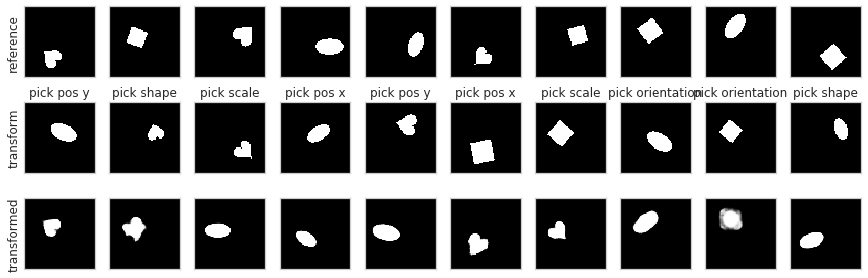

In [9]:
sns.set_style("whitegrid", {'axes.grid' : False})

transforms = get_transforms(data[0], composer)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.T

images, dim = data[0]
ref, changes = images.chunk(2, 1)
ref = ref.squeeze(1)
changes = changes.squeeze(1)
dim = dim.to(dtype=torch.long)

for r, c, d, t, ax in zip(ref, changes, dim, transforms, axes):
    ax[0].imshow(r.reshape(64, 64), cmap='Greys_r')
    
    ax[1].set_title('pick {}'.format(factors[d.nonzero().item() - 1]))
    ax[1].imshow(c.reshape(64, 64), cmap='Greys_r')
    
    ax[2].imshow(t.reshape(64, 64), cmap='Greys_r')
    
axes[0, 0].set_ylabel('reference')
axes[0, 1].set_ylabel('transform')
axes[0, 2].set_ylabel('transformed')
    
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig(presentation_folder + 'composition_full_extrp_test_trans.pdf')

## Leave-one-out translation

In [60]:
factors = ['shape', 'scale', 'orientation', 'pos x', 'pos y']
composer = load_composer('../data/sims/composition/19/', device)

In [24]:
try:
    del data
except NameError:
    pass

try:
    del metric_data
except NameError:
    pass

try:
    del disentanglement_metric
except NameError:
    pass

try:
    del raw
except NameError:
    pass

try:
    del raw_extrp_test
except NameError:
    pass

gc.collect()

2726

In [25]:
raw = load_triplets(dsprite_path ,'../data/preproc/triplets/leave1out_trans_train.npz')
training_scores = model_scores([composer], raw)

del raw
gc.collect()

raw_extrp_test = load_triplets(dsprite_path, '../data/preproc/triplets/leave1out_trans_test.npz')
test_scores = model_scores([composer], raw_extrp_test)

del raw_extrp_test
gc.collect()

dim_compgen_scores = pd.concat([training_scores, test_scores], keys=['training', 'test'], names=['dataset'])

In [26]:
raw = load_dsprites(dsprite_path, filters.leave1out_trans_train)

metric_data =  SupervisedLoader(lambda z, c: z[:, 1:], raw, 200)
disentanglement_metric = EastwoodScore(metric_data, n_factors=5)

training_scores = disentanglement_metric(composer.vae)
training_scores_R = disentanglement_metric.R_

In [27]:
raw = load_dsprites(dsprite_path, filters.leave1out_trans_extrp)

metric_data =  SupervisedLoader(lambda z, c: z[:, 1:], raw, 200)
disentanglement_metric = EastwoodScore(metric_data, n_factors=5)

test_scores = disentanglement_metric(composer.vae)
test_scores_R = disentanglement_metric.R_

../src/analysis/metrics.py:171: RuntimeWarning: invalid value encountered in true_divide
  y = (y - y.mean(axis=0)) / y.std(axis=0)


In [28]:
total_disent_score, disent_scores, completness_scores = zip(training_scores, test_scores)
R_matrices = [training_scores_R, test_scores_R]

In [29]:
data_names = ['train', 'test']

idx = pd.MultiIndex.from_product([data_names, range(len(disent_scores[0]))], names=['data', 'latent'])
disent_scores = pd.Series(np.concatenate(disent_scores), index=idx)
disent_scores.name = 'disentanglement'

idx = pd.MultiIndex.from_product([data_names, factors], names=['data', 'factor'])
completness_scores = pd.Series(np.concatenate(completness_scores), index=idx)
completness_scores.name = 'completeness'

idx = pd.MultiIndex.from_product([data_names], names=['data'])
overall_disent_score = pd.Series(total_disent_score, index=idx)
overall_disent_score.name = 'overall disentanglement'

dim_compgen_disent = overall_disent_score

In [ ]:
from analysis.hinton import hinton

fig, axes = plt.subplots(1, 2, figsize=(5, 5), sharey=True)

for i in range(len(data_names)):
    hinton(R_matrices[i], 'factor', 'latent', ax=axes[i], fontsize=18)
    axes[i].set_title('{0}'.format(data_names[i]), fontsize=20)
    

axes[1].set_ylabel('')

fig.savefig(presentation_folder + 'composition_leave1out_trans_rmatrix.pdf')

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, axes = plt.subplots(1, 3, figsize=(20, 5))


sns.barplot(data=disent_scores.reset_index(), hue='data', x='latent', y='disentanglement', ax=axes[0])
sns.barplot(data=overall_disent_score.reset_index(), hue='data', x='data', y='overall disentanglement', ax=axes[1])
sns.barplot(data=completness_scores.reset_index(), hue='data', x='factor', y='completeness', ax=axes[2])

axes[0].legend_.remove()
axes[1].legend_.remove()

fig.savefig(presentation_folder + 'composition_full_extrp_dis.pdf')

### Training data reconstructions

In [61]:
data = load_triplets(dsprite_path ,'../data/preproc/triplets/leave1out_trans_train.npz')
data = next(iter(Unsupervised(data, 10, shuffle=True, random_state=1234)))

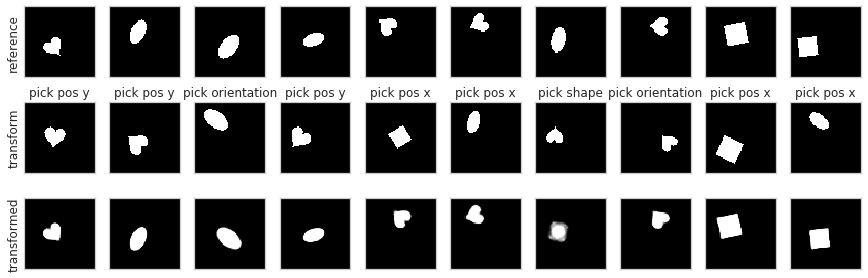

In [62]:
sns.set_style("whitegrid", {'axes.grid' : False})

transforms = get_transforms(data[0], composer)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.T

images, dim = data[0]
ref, changes = images.chunk(2, 1)
ref = ref.squeeze(1)
changes = changes.squeeze(1)
dim = dim.to(dtype=torch.long)

for r, c, d, t, ax in zip(ref, changes, dim, transforms, axes):
    ax[0].imshow(r.reshape(64, 64), cmap='Greys_r')
    
    ax[1].set_title('pick {}'.format(factors[d.nonzero().item() - 1]))
    ax[1].imshow(c.reshape(64, 64), cmap='Greys_r')
    
    ax[2].imshow(t.reshape(64, 64), cmap='Greys_r')
    
axes[0, 0].set_ylabel('reference')
axes[0, 1].set_ylabel('transform')
axes[0, 2].set_ylabel('transformed')
    
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig(presentation_folder + 'composition_loo_trans_train.pdf')

### Test data reconstructions

In [63]:
data = load_triplets(dsprite_path,'../data/preproc/triplets/leave1out_trans_test.npz')
data = next(iter(Unsupervised(data, 10, shuffle=True, random_state=1234)))

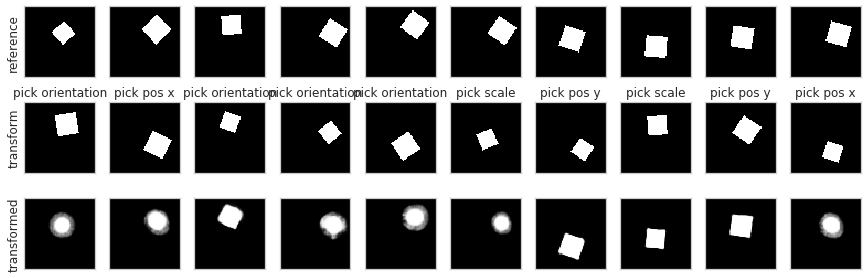

In [64]:
sns.set_style("whitegrid", {'axes.grid' : False})

transforms = get_transforms(data[0], composer)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.T

images, dim = data[0]
ref, changes = images.chunk(2, 1)
ref = ref.squeeze(1)
changes = changes.squeeze(1)
dim = dim.to(dtype=torch.long)

for r, c, d, t, ax in zip(ref, changes, dim, transforms, axes):
    ax[0].imshow(r.reshape(64, 64), cmap='Greys_r')
    
    ax[1].set_title('pick {}'.format(factors[d.nonzero().item() - 1]))
    ax[1].imshow(c.reshape(64, 64), cmap='Greys_r')
    
    ax[2].imshow(t.reshape(64, 64), cmap='Greys_r')
    
axes[0, 0].set_ylabel('reference')
axes[0, 1].set_ylabel('transform')
axes[0, 2].set_ylabel('transformed')
    
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig(presentation_folder + 'composition_loo_trans_test.pdf')

►## Range combinatorial generalisation

In [65]:
factors = ['shape', 'scale', 'orientation', 'pos x', 'pos y']
composer = load_composer('../data/sims/composition/18/', device)

In [31]:
try:
    del data
except NameError:
    pass

try:
    del metric_data
except NameError:
    pass

try:
    del disentanglement_metric
except NameError:
    pass

try:
    del raw
except NameError:
    pass

try:
    del raw_extrp_test
except NameError:
    pass

gc.collect()

22

In [32]:
raw = load_triplets(dsprite_path ,'../data/preproc/triplets/leave1out_comb_train.npz')
training_scores = model_scores([composer], raw)

del raw
gc.collect()

raw_extrp_test = load_triplets(dsprite_path, '../data/preproc/triplets/leave1out_comb_test.npz')
test_scores = model_scores([composer], raw_extrp_test)

del raw_extrp_test
gc.collect()

local_combgen_scores = pd.concat([training_scores, test_scores], keys=['training', 'test'], names=['dataset'])

In [71]:
raw = load_dsprites(dsprite_path, filters.leave1out_comb_train)

metric_data =  SupervisedLoader(lambda z, c: z[:, 1:], raw, 200)
disentanglement_metric = EastwoodScore(metric_data, n_factors=5)

training_scores = disentanglement_metric(composer.vae)
training_scores_R = disentanglement_metric.R_

In [75]:
raw = load_dsprites(dsprite_path, filters.leave1out_comb_test)

metric_data =  SupervisedLoader(lambda z, c: z[:, 1:], raw, 200)
disentanglement_metric = EastwoodScore(metric_data, n_factors=5)

test_scores = disentanglement_metric(composer.vae)
test_scores_R = disentanglement_metric.R_

../src/analysis/metrics.py:171: RuntimeWarning: invalid value encountered in true_divide
  y = (y - y.mean(axis=0)) / y.std(axis=0)


In [77]:
total_disent_score, disent_scores, completness_scores = zip(training_scores, test_scores)
R_matrices = [training_scores_R, test_scores_R]

In [78]:
data_names = ['train', 'test']

idx = pd.MultiIndex.from_product([data_names, range(len(disent_scores[0]))], names=['data', 'latent'])
disent_scores = pd.Series(np.concatenate(disent_scores), index=idx)
disent_scores.name = 'disentanglement'

idx = pd.MultiIndex.from_product([data_names, factors], names=['data', 'factor'])
completness_scores = pd.Series(np.concatenate(completness_scores), index=idx)
completness_scores.name = 'completeness'

idx = pd.MultiIndex.from_product([data_names], names=['data'])
overall_disent_score = pd.Series(total_disent_score, index=idx)
overall_disent_score.name = 'overall disentanglement'

local_combgen_disent = overall_disent_score

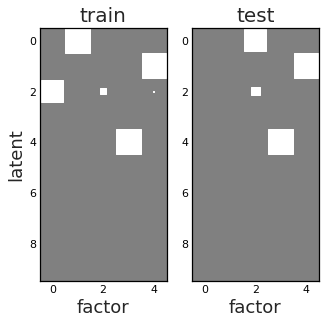

In [81]:
from analysis.hinton import hinton

fig, axes = plt.subplots(1, 2, figsize=(5, 5), sharey=False)

for i in range(len(data_names)):
    hinton(R_matrices[i], 'factor', 'latent', ax=axes[i], fontsize=18)
    axes[i].set_title('{0}'.format(data_names[i]), fontsize=20)
    

axes[1].set_ylabel('')

fig.savefig(presentation_folder + 'composition_leave1out_comb_rmatrix.pdf')

## Training reconstructions

In [68]:
data = load_triplets(dsprite_path ,'../data/preproc/triplets/leave1out_comb_train.npz')
data = next(iter(Unsupervised(data, 10, shuffle=True, random_state=1234)))

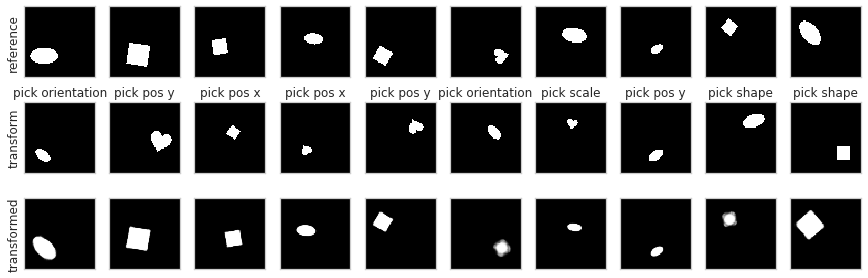

In [69]:
sns.set_style("whitegrid", {'axes.grid' : False})

transforms = get_transforms(data[0], composer)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.T

images, dim = data[0]
ref, changes = images.chunk(2, 1)
ref = ref.squeeze(1)
changes = changes.squeeze(1)
dim = dim.to(dtype=torch.long)

for r, c, d, t, ax in zip(ref, changes, dim, transforms, axes):
    ax[0].imshow(r.reshape(64, 64), cmap='Greys_r')
    
    ax[1].set_title('pick {}'.format(factors[d.nonzero().item() - 1]))
    ax[1].imshow(c.reshape(64, 64), cmap='Greys_r')
    
    ax[2].imshow(t.reshape(64, 64), cmap='Greys_r')
    
axes[0, 0].set_ylabel('reference')
axes[0, 1].set_ylabel('transform')
axes[0, 2].set_ylabel('transformed')
    
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig(presentation_folder + 'composition_loo_comb_train.pdf')

## Test reconstructions

In [66]:
data = load_triplets(dsprite_path,'../data/preproc/triplets/leave1out_comb_test.npz')
data = next(iter(Unsupervised(data, 10, shuffle=True, random_state=1234)))

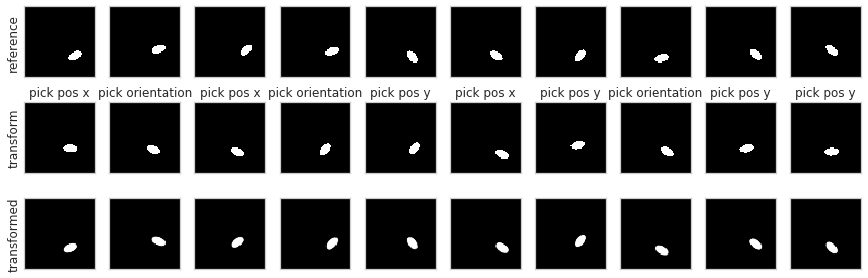

In [67]:
sns.set_style("whitegrid", {'axes.grid' : False})

transforms = get_transforms(data[0], composer)

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
axes = axes.T

images, dim = data[0]
ref, changes = images.chunk(2, 1)
ref = ref.squeeze(1)
changes = changes.squeeze(1)
dim = dim.to(dtype=torch.long)

for r, c, d, t, ax in zip(ref, changes, dim, transforms, axes):
    ax[0].imshow(r.reshape(64, 64), cmap='Greys_r')
    
    ax[1].set_title('pick {}'.format(factors[d.nonzero().item() - 1]))
    ax[1].imshow(c.reshape(64, 64), cmap='Greys_r')
    
    ax[2].imshow(t.reshape(64, 64), cmap='Greys_r')
    
axes[0, 0].set_ylabel('reference')
axes[0, 1].set_ylabel('transform')
axes[0, 2].set_ylabel('transformed')
    
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.savefig(presentation_folder + 'composition_loo_comb_test.pdf')

In [53]:
recons_scores = [full_extrapolation_scores, dim_compgen_scores, local_combgen_scores]

recons_scores = pd.concat(recons_scores, keys=['extrapolation', 'dim combgen', 'local combgen'])
recons_scores = recons_scores.reset_index()
del recons_scores['level_2']
recons_scores.columns = ['experiment', 'dataset', 'nll']

training_scores = recons_scores[recons_scores['dataset']=='training']
test_scores = recons_scores[recons_scores['dataset']=='test']
del training_scores['dataset']
del test_scores['dataset']

disent_scores = [full_extrapolation_disent, dim_compgen_disent, local_combgen_disent]
disent_scores = pd.concat(disent_scores, keys=['extrapolation', 'dim combgen', 'local combgen'], names=['experiment'])
disent_scores = disent_scores.reset_index()
disent_scores.columns = ['experiment', 'dataset', 'disent']

training_disent = disent_scores[disent_scores['dataset']=='train']
test_disent = disent_scores[disent_scores['dataset']=='test']
del training_disent['dataset']
del test_disent['dataset']

recons = pd.merge(training_scores, test_scores, on=['experiment'])
disent = pd.merge(training_disent, test_disent, on=['experiment'])

all_scores = pd.merge(recons, disent, on=['experiment'])
all_scores.columns = ['experiment', 'training nll', 'test nll', 'train disent', 'test_disent']

all_scores.to_latex('/home/milton/Dropbox/Apps/Overleaf/ICLR 2021: Disentanglment and Compositionality/tables/comp-scores-range.tex')